In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  9 00:24:28 2020

@author: healthhub
"""


import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import pathlib
import random
from tqdm import tqdm
from PIL import Image

import os, sys
os.environ['CUDA_VISIBLE_DEVICES']= '0'

In [3]:
from keras import applications

In [4]:
import argparse
import time
import random
import cv2
import numpy as np
import keras
import glob

from keras.utils import np_utils
#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, ZeroPadding2D, GlobalAveragePooling2D, concatenate
from keras.layers import BatchNormalization, ReLU, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.models import Model

from sklearn.utils import class_weight

IMSIZE = 128, 128
RANDOM_SEED = 1234
DATASET_PATH = '/home/centos/knee/kneeKL224'

In [6]:
def normalize(img):
    mat = np.zeros(img.shape, dtype=np.int16)
    h, w = img.shape[:2]
    m1 = img.min()
    m2 = img.max()
    for j in range(h):
        for i in range(w):
            mat[j, i] = ((img[j, i] - m1) / (m2 - m1)) * 255
    return mat

In [7]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [8]:
def find_joint(img):
    cols = img.sum(axis = 1)
    cols = np.array(cols,dtype='int64')
    slope = []
    for i in range(100, len(cols)-1):
        slope.append(float(cols[i+1] - cols[i]))
    j = np.argmin(slope) + 100
    return j

In [11]:
def Class2Label(cls):
    lb = [0] * 5
    lb[int(cls)] = 1
    return lb

def DataLoad(imdir, joint = False):
    folders = glob.glob(os.path.join(imdir,'*'))
    img_a = []
    img_b = []
    img_c = []
    lb = []
    cls = []
    lr = []
    for folder in folders:
        impath = glob.glob(os.path.join(folder,'*.png'))
        label = folder[-1]
        print('Loading', len(impath), label, 'images ...', 'HOHO')
        for i, p in enumerate(impath):
            img_whole = cv2.imread(p,0)
            h, w = img_whole.shape
            if impath[0][-5] == 'L':
                if joint == True:
                    j = find_joint(img_whole)
                    im
                else:
                    im_a = img_whole[int(224*0.3):int(224*0.8), :int(224*0.5)]
                    im_b = img_whole[int(224*0.3):int(224*0.8), int(224*0.5):]
                    im_c = img_whole[int(224*0.3):int(224*0.8), int(224*0.25):int(224*0.75)]
                img_a.append(im_a)
                img_b.append(im_b)
                img_c.append(im_c)
                lb.append(Class2Label(label))
                cls.append(int(label))
                lr.append(0)
            elif impath[0][-5] == 'R':
                im_b = img_whole[int(224*0.3):int(224*0.8), :int(224*0.5)]
                im_a = img_whole[int(224*0.3):int(224*0.8), int(224*0.5):]
                im_c = img_whole[int(224*0.3):int(224*0.8), int(224*0.25):int(224*0.75)]
                img_a.append(im_a)
                img_b.append(im_b)
                img_c.append(im_c)
                lb.append(Class2Label(label))
                cls.append(int(label))
                lr.append(1)
    return img_a, img_b, img_c, lb, np.array(cls), lr

def ImagePreprocessing(img):
    h, w = IMSIZE
    print('Preprocessing ...')
    for i, im, in tqdm(enumerate(img)):
        tmp = cv2.resize(im, dsize=(w, h), interpolation=cv2.INTER_AREA)
        tmp = NormalizeData(cv2.equalizeHist(tmp))
        img[i] = tmp
    print(len(img), 'images processed!')
    return img

In [12]:
imageA, imageB, _, labels, classes, lr = DataLoad(os.path.join(DATASET_PATH, 'train'))
imageA = ImagePreprocessing(imageA)
imageA = np.array(imageA)
imageA = np.expand_dims(imageA, axis=-1)

imageB = ImagePreprocessing(imageB)
imageB = np.array(imageB)
imageB = np.expand_dims(imageB, axis=-1)

labels = np.array(labels)
lr = np.array(lr)

# dataset = [[X, Y, Z1, Z2] for X, Y, Z1, Z2 in zip(imageA, imageB, labels, lr)]
# random.shuffle(dataset)

Xa_train = imageA
Xb_train = imageB
Y_train = labels
Yb_train = lr 

Loading 2286 0 images ... HOHO
Loading 1046 1 images ... HOHO
Loading 1516 2 images ... HOHO
Loading 757 3 images ... HOHO


0it [00:00, ?it/s]

Loading 173 4 images ... HOHO
Preprocessing ...


5778it [00:01, 3941.55it/s]


5778 images processed!


400it [00:00, 3994.25it/s]

Preprocessing ...


5778it [00:01, 3990.41it/s]


5778 images processed!


In [13]:
imageA, imageB, _, labels, classes, lr = DataLoad(os.path.join(DATASET_PATH, 'val'))
imageA = ImagePreprocessing(imageA)
imageA = np.array(imageA)
imageA = np.expand_dims(imageA, axis=-1)

imageB = ImagePreprocessing(imageB)
imageB = np.array(imageB)
imageB = np.expand_dims(imageB, axis=-1)

labels = np.array(labels)
lr = np.array(lr)

# dataset = [[X, Y, Z1, Z2] for X, Y, Z1, Z2 in zip(imageA, imageB, labels, lr)]
# random.shuffle(dataset)

Xa_val = imageA
Xb_val = imageB
Y_val = labels
Yb_val = lr 

Loading 328 0 images ... HOHO
Loading 153 1 images ... HOHO
Loading 212 2 images ... HOHO


0it [00:00, ?it/s]

Loading 106 3 images ... HOHO
Loading 27 4 images ... HOHO
Preprocessing ...


826it [00:00, 6139.28it/s]
826it [00:00, 6103.65it/s]


826 images processed!
Preprocessing ...
826 images processed!


In [14]:
imageA, imageB, _,  labels, classes, lr = DataLoad(os.path.join(DATASET_PATH, 'test'))
imageA = ImagePreprocessing(imageA)
imageA = np.array(imageA)
imageA = np.expand_dims(imageA, axis=-1)

imageB = ImagePreprocessing(imageB)
imageB = np.array(imageB)
imageB = np.expand_dims(imageB, axis=-1)

labels = np.array(labels)
lr = np.array(lr)

# dataset = [[X, Y, Z1, Z2] for X, Y, Z1, Z2 in zip(imageA, imageB, labels, lr)]
# random.shuffle(dataset)

Xa_test = imageA
Xb_test = imageB
Y_test = labels
Yb_test = lr 

Loading 639 0 images ... HOHO
Loading 296 1 images ... HOHO
Loading 447 2 images ... HOHO
Loading 223 3 images ... HOHO
Loading 51 4 images ... HOHO


634it [00:00, 6338.87it/s]

Preprocessing ...


1656it [00:00, 6344.31it/s]
0it [00:00, ?it/s]

1656 images processed!
Preprocessing ...


1656it [00:00, 6326.36it/s]


1656 images processed!


In [15]:
Xa_data = np.concatenate([Xa_train, Xa_val, Xa_test])
Xb_data = np.concatenate([Xb_train, Xb_val, Xb_test])
Ya_data = np.concatenate([Y_train, Y_val, Y_test])
Yb_data = np.concatenate([Yb_train, Yb_val, Yb_test])

In [16]:
dataset = [[X, Y, Z1, Z2] for X, Y, Z1, Z2 in zip(Xa_data, Xb_data, Ya_data, Yb_data)]
random.shuffle(dataset)

Xa_data = np.array([n[0] for n in dataset])
Xb_data = np.array([n[1] for n in dataset])
Ya_data = np.array([n[2] for n in dataset])
Yb_data = np.array([n[3] for n in dataset])

In [17]:
def create_convolution_layers(input_img):
    input_shape = (128, 128, 1)
    model = Conv2D(32, (3, 3), strides = (2, 2), padding='same', input_shape=input_shape)(input_img)
    model = BatchNormalization()(model)
    model = ReLU()(model)

    model = Conv2D(32, (3, 3), strides = (1, 1), padding='same', input_shape=input_shape)(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)

    model = Conv2D(32, (3, 3), strides = (1, 1), padding='same', input_shape=input_shape)(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)

    model = MaxPooling2D(pool_size = (2,2), padding = 'same')(model)

    model = Conv2D(64, (3, 3), strides = (1, 1), padding='same', input_shape=input_shape)(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)

    model = Conv2D(64, (3, 3), strides = (1, 1), padding='same', input_shape=input_shape)(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)

    model = MaxPooling2D(pool_size = (2,2), padding = 'same')(model)    

    model = Conv2D(128, (3, 3), strides = (1, 1), padding='same', input_shape=input_shape)(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = GlobalAveragePooling2D()(model)
    
    return model

In [18]:
def create_model():
    input_shape = (128, 128, 1)
    num_classes = 5 

    imageA_input = Input(shape=(128, 128, 1))
    imageA_model = create_convolution_layers(imageA_input)

    imageB_input = Input(shape=(128, 128, 1))
    imageB_model = create_convolution_layers(imageB_input)

    conv = concatenate([imageA_model, imageB_model])

    conv = Flatten()(conv)

    dense = Dense(512)(conv)
    y1 = Dense(5, activation='softmax', name = 'kl_grade')(dense)
    y2 = Dense(1, activation = 'sigmoid', name = 'side')(dense)

    model = Model(inputs=[imageA_input, imageB_input], outputs = [y1, y2])
    return model 

In [19]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = KFold(n_splits = 5)

In [20]:
kf.split(Xa_data)

<generator object _BaseKFold.split at 0x7fe2bf4a2ba0>

In [22]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

kf = KFold(n_splits = 5)
# skf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True) 

idx = 0
all_scores = []
all_preds = []
for train_index, test_index in kf.split(Xa_data):
    
    Xa_train, Xa_test = Xa_data[train_index], Xa_data[test_index]
    Xb_train, Xb_test = Xb_data[train_index], Xb_data[test_index]
    Ya_train, Ya_test = Ya_data[train_index], Ya_data[test_index]
    Yb_train, Yb_test = Yb_data[train_index], Yb_data[test_index]
    
    model = create_model()
    model.load_weights('./models/tito(77.4).hdf5')
    
    
    loss_list = ['categorical_crossentropy','binary_crossentropy']
    test_metrics = {'kl_grade': 'categorical_accuracy','side': 'binary_accuracy'}
    adam = optimizers.Adam(lr=0.0001, decay=1e-5)
    
    model.compile(loss=loss_list, loss_weights = [0.75, 0.35], optimizer=adam, metrics=test_metrics)
    
    '''
    hist = model.fit([Xa_train, Xb_train], [Ya_train, Yb_train],
                 batch_size=8,
                 epochs =15, 
                 shuffle=False
                 )
    '''
    
    pred = model.predict([Xa_test, Xb_test])
    pred = pred[0].argmax(axis=1)
    actual = Ya_test.argmax(axis=1)
    accuracy = (pred == actual).sum()/len(pred)

    print('Accuraccy of the model is....', accuracy)

    correct = []
    wrong = []
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            correct.append(pred[i])
        else:
            wrong.append(actual[i])

    print('predicted 0 correctly', (np.array(correct) == 0 ).sum(), 'out of', (actual == 0).sum())
    print('predicted 1 correctly', (np.array(correct) ==  1).sum(), 'out of', (actual == 1).sum())
    print('predicted 2 correctly', (np.array(correct) ==  2).sum(), 'out of', (actual == 2).sum())
    print('predicted 3 correctly', (np.array(correct) == 3).sum(), 'out of', (actual == 3).sum())
    print('predicted 4 correctly', (np.array(correct) ==  4).sum(), 'out of', (actual == 4).sum())
    
    scores = model.evaluate([Xa_test, Xb_test], [Ya_test, Yb_test])
    all_scores.append(scores)
    
    all_preds.append(confusion_matrix(pred, actual))
    

Accuraccy of the model is.... 0.8232445520581114
predicted 0 correctly 628 out of 663
predicted 1 correctly 61 out of 278
predicted 2 correctly 411 out of 411
predicted 3 correctly 220 out of 240
predicted 4 correctly 40 out of 60
52/52 [==============================] - 0s 6ms/step - loss: 0.3970 - kl_grade_loss: 0.5294 - side_loss: 2.6785e-05 - kl_grade_categorical_accuracy: 0.8232 - side_binary_accuracy: 1.0000
Accuraccy of the model is.... 0.8141646489104116
predicted 0 correctly 624 out of 652
predicted 1 correctly 58 out of 294
predicted 2 correctly 448 out of 448
predicted 3 correctly 190 out of 212
predicted 4 correctly 25 out of 46
52/52 [==============================] - 0s 6ms/step - loss: 0.4191 - kl_grade_loss: 0.5588 - side_loss: 2.3801e-05 - kl_grade_categorical_accuracy: 0.8142 - side_binary_accuracy: 1.0000
Accuraccy of the model is.... 0.8117433414043583
predicted 0 correctly 629 out of 646
predicted 1 correctly 50 out of 299
predicted 2 correctly 441 out of 441
predi

In [25]:
scores = [0.8232445520581114,0.8141646489104116, 0.8117433414043583,0.7863196125907991, 0.799636803874092]

In [26]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=2)

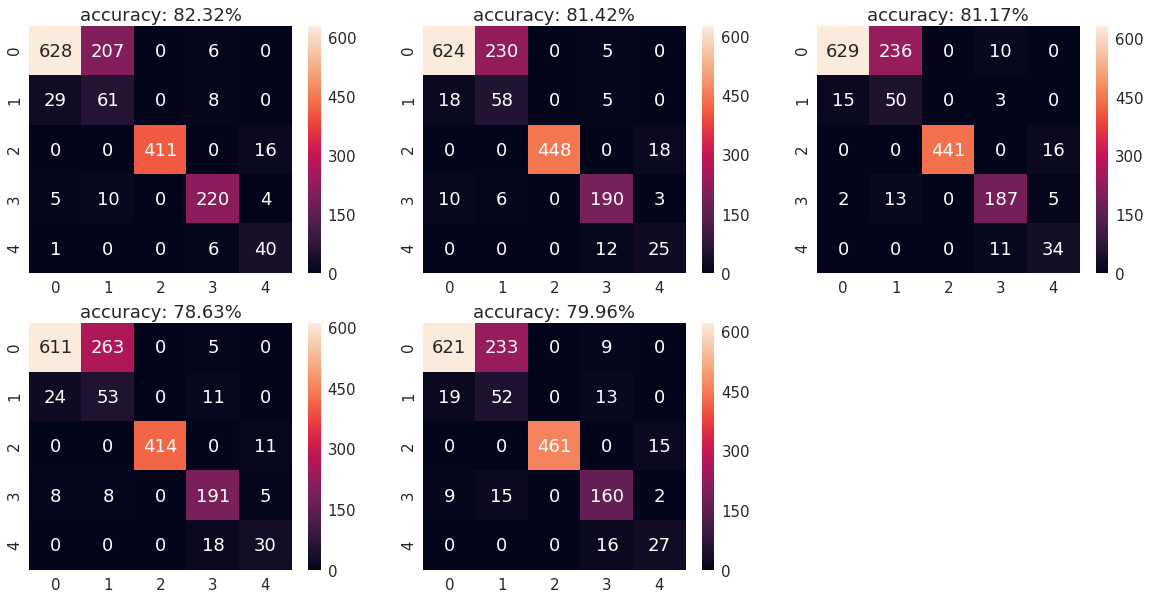

In [27]:
w=10
h=10
fig=plt.figure(figsize=(20, 10))
columns = 3
rows = 2
sns.set(font_scale=1.5)
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    sns.heatmap(all_preds[i-1], annot=True, fmt='g')
    plt.title(f'accuracy: {round(scores[i-1] * 100, 2)}%')
plt.savefig('./figures/kfold_tito_confusion.png', dpi = 300)

In [42]:
def prop_confusion_matrix(mat):
    test = []
    sum0 = sum(mat[i][0] for i in range(5))
    sum1 = sum(mat[i][1] for i in range(5))
    sum2 = sum(mat[i][2] for i in range(5))
    sum3 = sum(mat[i][3] for i in range(5))
    sum4 = sum(mat[i][4] for i in range(5))
    for i in range(5):
        new_line = [mat[i][0]/sum0, mat[i][1]/sum1, mat[i][2]/sum2, mat[i][3]/sum3, mat[i][4]/sum4]
        new_line = [round(x *100, 2) for x in new_line]
        test.append(new_line)
    return np.array(test)

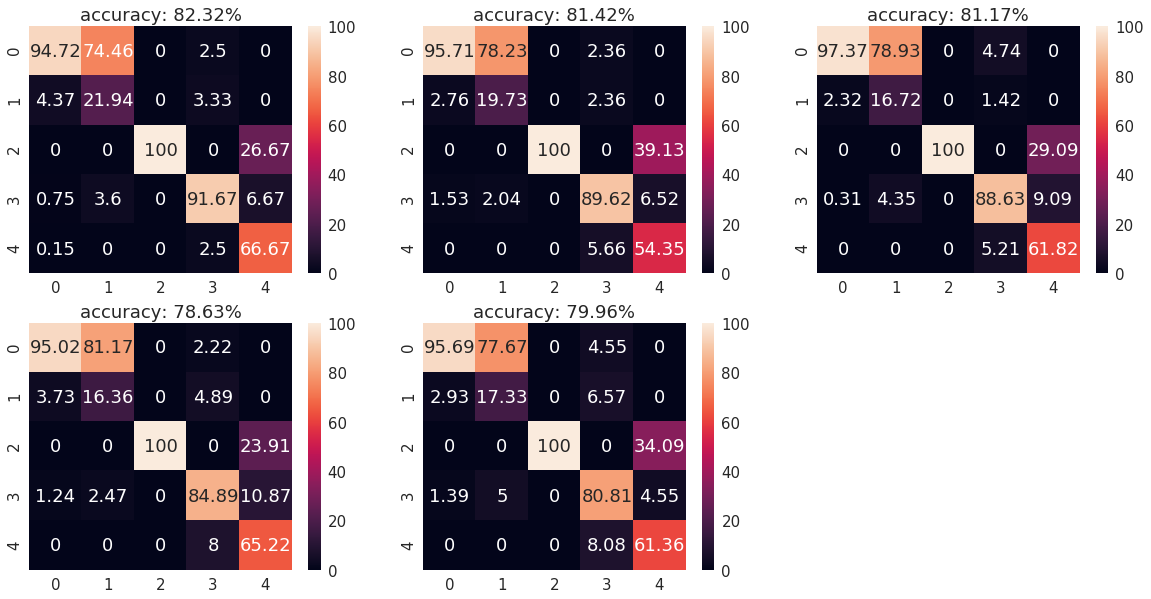

In [50]:
w=10
h=10
fig=plt.figure(figsize=(20, 10))
columns = 3
rows = 2
sns.set(font_scale=1.5)
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    sns.heatmap(prop_confusion_matrix(all_preds[i-1]), annot=True, fmt='g')
    plt.title(f'accuracy: {round(scores[i-1] * 100, 2)}%')
plt.show()

In [28]:
np.mean(np.array(scores))

0.8070217917675546